<a href="https://colab.research.google.com/github/M-PRERNA/MACHINE-LEARNING/blob/main/Transfer_learning_Cats_and_Dogs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Tensrflow hub and Transfer learning

*TensorFlow Hub* is an online repository of already trained TensorFlow models that can be used. These models can either be used as is, or they can be used for Transfer Learning.

Transfer learning is a process where we take an existing trained model, and extend it to do additional work. This involves leaving the bulk of the model unchanged, while adding and retraining the final layers, in order to get a different set of possible outputs.

## Importing modules

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pylab as plt

# new libraries
import tensorflow_hub as hub
import tensorflow_datasets as tfds

# neural network layers
from tensorflow.keras import layers

import logging
logger = tf.get_logger()
logger.setLevel(logging.ERROR)


## PART 1: Using MobileNet for random prediction (a pretrained model from TensorFlow Hub)
The model that we'll use is MobileNet v2 

1.   List item
2.   List item



#### 1. Downloding the classifier
Downloading the MobileNet model and create a Keras model from it. MobileNet is expecting images of 224  ×  224 pixels, in 3 color channels (RGB).

In [2]:
CLASSIFIER_URL='https://tfhub.dev/google/tf2-preview/mobilenet_v2/classification/2'
IMAGE_RES = 224

model = tf.keras.Sequential([
  hub.KerasLayer(CLASSIFIER_URL,input_shape = (IMAGE_RES,IMAGE_RES,3))
])

MobileNet has been trained on the ImageNet dataset. ImageNet has 1000 different output classes, and one of them is military uniforms. Let's get an image containing a military uniform that is not part of ImageNet, and see if our model can predict that it is a military uniform.

65536/61306 [================================] - 0s 0us/step


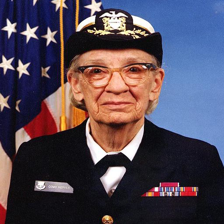

In [3]:
import PIL.Image as Image

grace_hopper = tf.keras.utils.get_file('image.jpg','https://storage.googleapis.com/download.tensorflow.org/example_images/grace_hopper.jpg')
grace_hopper = Image.open(grace_hopper).resize((IMAGE_RES, IMAGE_RES))
grace_hopper 

In [4]:
grace_hopper = np.array(grace_hopper)/255.0
grace_hopper.shape

(224, 224, 3)

In [5]:
result = model.predict(grace_hopper[np.newaxis, ...])
result.shape

(1, 1001)

The result is a 1001 element vector of logits, rating the probability of each class for the image.

So the top class ID can be found with argmax. But how can we know what class this actually is and in particular if that class ID in the ImageNet dataset denotes a military uniform or something else?

In [6]:
predicted_class = np.argmax(result[0],axis = -1)
predicted_class

653

#### to decode the predicted class
To see what our predicted_class is in the ImageNet dataset, download the ImageNet labels and fetch the row that the model predicted.

16384/10484 [==============================================] - 0s 0us/step


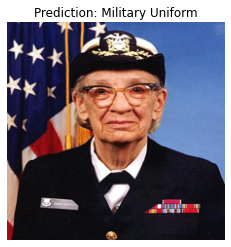

In [7]:
# opening the imagenet labels file
labels_path = tf.keras.utils.get_file('ImageNetLabels.txt','https://storage.googleapis.com/download.tensorflow.org/data/ImageNetLabels.txt')
imagenet_labels = np.array(open(labels_path).read().splitlines())
# checking the predicted class
plt.imshow(grace_hopper)
plt.axis('off')
predicted_class_name = imagenet_labels[predicted_class]
_ = plt.title("Prediction: " + predicted_class_name.title())

## Using MobileNet for Cats and Dogs dataset
We can use TensorFlow Datasets to load the Dogs vs Cats dataset.

In [8]:
# using tensorflow datasets cats_vs_dogs
(train_examples, validation_examples), info = tfds.load(
    'cats_vs_dogs', 
    with_info=True, 
    as_supervised=True, 
    split=['train[:80%]', 'train[80%:]'],
)

num_examples = info.splits['train'].num_examples
num_classes = info.features['label'].num_classes

Shuffling and writing examples to /root/tensorflow_datasets/cats_vs_dogs/4.0.0.incompleteXBUABH/cats_vs_dogs-train.tfrecord


Dataset cats_vs_dogs downloaded and prepared to /root/tensorflow_datasets/cats_vs_dogs/4.0.0. Subsequent calls will reuse this data.


In [9]:
for i,example_image in enumerate(train_examples.take(3)):
  print("Image {} shape: {}".format(i+1, example_image[0].shape))

Image 1 shape: (262, 350, 3)
Image 2 shape: (409, 336, 3)
Image 3 shape: (493, 500, 3)


So we need to reformat all images to the resolution expected by MobileNet (224, 224).

The .repeat() and steps_per_epoch here is not required, but saves ~15s per epoch, since the shuffle-buffer only has to cold-start once.

In [10]:
def format_image(image, label):
  image = tf.image.resize(image, (IMAGE_RES, IMAGE_RES))/255.0
  return image, label

BATCH_SIZE = 32

train_batches      = train_examples.shuffle(num_examples//4).map(format_image).batch(BATCH_SIZE).prefetch(1)
validation_batches = validation_examples.map(format_image).batch(BATCH_SIZE).prefetch(1)

#### Running the classifier on batch of images

In [11]:
image_batch, label_batch = next(iter(train_batches.take(1)))
image_batch = image_batch.numpy()
label_batch = label_batch.numpy()

result_batch = model.predict(image_batch)

predicted_class_names = imagenet_labels[np.argmax(result_batch, axis=-1)]
predicted_class_names

array(['Angora', 'German shepherd', 'Angora', 'miniature schnauzer',
       'Siamese cat', 'Persian cat', 'lynx', 'Egyptian cat', 'tabby',
       'Persian cat', 'basset', 'Rhodesian ridgeback', 'Persian cat',
       'Doberman', 'Boston bull', 'Newfoundland', 'skunk', 'tiger cat',
       'Egyptian cat', 'Egyptian cat', 'tiger cat', 'Egyptian cat',
       'hamster', 'Great Dane', 'tabby', 'Eskimo dog',
       'miniature pinscher', 'Egyptian cat', 'toy terrier', 'Siamese cat',
       'Labrador retriever', 'Labrador retriever'], dtype='<U30')

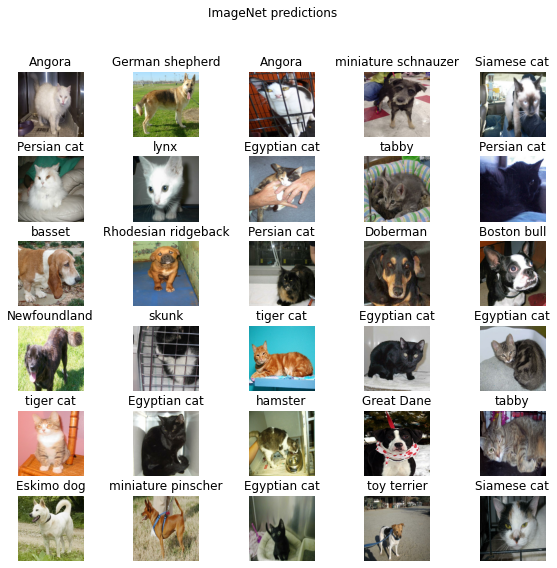

In [12]:
plt.figure(figsize=(10,9))
for n in range(30):
  plt.subplot(6,5,n+1)
  plt.subplots_adjust(hspace = 0.3)
  plt.imshow(image_batch[n])
  plt.title(predicted_class_names[n])
  plt.axis('off')
_ = plt.suptitle("ImageNet predictions")

# Part 3: Do simple transfer learning with TensorFlow Hub

Let's now use TensorFlow Hub to do Transfer Learning.

With transfer learning we reuse parts of an already trained model and change the final layer, or several layers, of the model, and then retrain those layers on our own dataset.

In addition to complete models, TensorFlow Hub also distributes models without the last classification layer. These can be used to easily do transfer learning. We will continue using MobileNet v2 because in later parts of this course, we will take this model and deploy it on a mobile device using [TensorFlow Lite](https://www.tensorflow.org/lite). Any [image feature vector URL from tfhub.dev](https://tfhub.dev/s?module-type=image-feature-vector&q=tf2) would work here.

We'll also continue to use the Dogs vs Cats dataset, so we will be able to compare the performance of this model against the ones we created from scratch earlier.

Note that we're calling the partial model from TensorFlow Hub (without the final classification layer) a `feature_extractor`. The reasoning for this term is that it will take the input all the way to a layer containing a number of features. So it has done the bulk of the work in identifying the content of an image, except for creating the final probability distribution. That is, it has extracted the features of the image.

In [13]:
URL = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/2"
feature_extractor = hub.KerasLayer(URL,
                                   input_shape=(IMAGE_RES, IMAGE_RES,3))

In [14]:
# run a batch of images through this, and see the final shape. 
# 32 is the number of images, and 1280 is the number of neurons in the last layer of the partial model from TensorFlow Hub.
feature_batch = feature_extractor(image_batch)
print(feature_batch.shape)

(32, 1280)


In [15]:
# Freeze the variables in the feature extractor layer, so that the training only modifies the final classifier layer.
feature_extractor.trainable = False

## Attaching a classification head

wrapping the hub layer within a tensorflow.keras.Sequential layer

In [16]:
model = tf.keras.Sequential([
        feature_extractor,
        layers.Dense(2)      
])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_1 (KerasLayer)   (None, 1280)              2257984   
_________________________________________________________________
dense (Dense)                (None, 2)                 2562      
Total params: 2,260,546
Trainable params: 2,562
Non-trainable params: 2,257,984
_________________________________________________________________


## Training the model (compile and fit)

In [17]:
model.compile(
  optimizer='adam',
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

EPOCHS = 6
history = model.fit(train_batches,
                    epochs=EPOCHS,
                    validation_data=validation_batches)

Epoch 1/6
582/582 [==============================] - 65s 98ms/step - loss: 0.1148 - accuracy: 0.9521 - val_loss: 0.0316 - val_accuracy: 0.9899
Epoch 2/6
582/582 [==============================] - 60s 95ms/step - loss: 0.0289 - accuracy: 0.9907 - val_loss: 0.0318 - val_accuracy: 0.9893
Epoch 3/6
582/582 [==============================] - 60s 95ms/step - loss: 0.0264 - accuracy: 0.9912 - val_loss: 0.0315 - val_accuracy: 0.9901
Epoch 4/6
582/582 [==============================] - 60s 95ms/step - loss: 0.0230 - accuracy: 0.9914 - val_loss: 0.0426 - val_accuracy: 0.9867
Epoch 5/6
582/582 [==============================] - 60s 95ms/step - loss: 0.0225 - accuracy: 0.9927 - val_loss: 0.0377 - val_accuracy: 0.9875
Epoch 6/6
582/582 [==============================] - 60s 94ms/step - loss: 0.0170 - accuracy: 0.9947 - val_loss: 0.0325 - val_accuracy: 0.9899


we can see that the validation accuracy has now become 98%

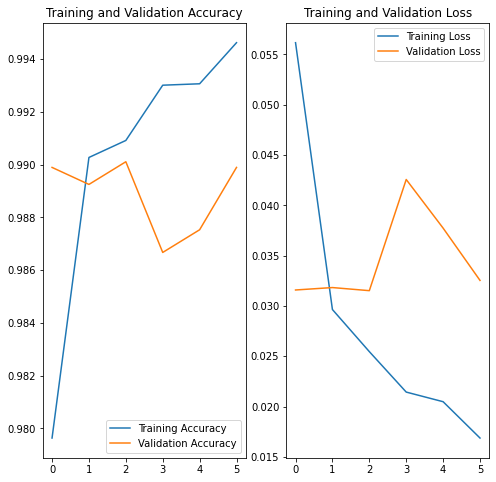

In [18]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(EPOCHS)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()